In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.covariance import EmpiricalCovariance
import faiss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import clip

In [3]:
# -----------------------------
# 1. Configuration and Utilities
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset for MVTec AD
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, subset, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform
        base = os.path.join(root_dir, category, subset)
        # good = label 0, others = label 1
        for cls in os.listdir(base):
            cls_dir = os.path.join(base, cls)
            if not os.path.isdir(cls_dir):
                continue
            label = 0 if cls == "good" else 1
            for fname in os.listdir(cls_dir):
                if fname.lower().endswith(('.png', '.jpg')):
                    self.paths.append(os.path.join(cls_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx], self.paths[idx]


# Evaluation function (common for all models)
def evaluate(model_predict_fn, test_loader, threshold):
    y_true, y_scores, y_pred = [], [], []
    for imgs, labels, _ in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        with torch.no_grad():
            scores = model_predict_fn(imgs)
        for score, true_label in zip(scores, labels):
            y_true.append(true_label)
            y_scores.append(score)
            y_pred.append(1 if score > threshold else 0)
    # Compute metrics
    roc_auc = roc_auc_score(y_true, y_scores)
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"], digits=4))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    return np.array(y_true), np.array(y_scores), np.array(y_pred), roc_auc


# Plot comparison of ROC curves
def plot_roc_curves(results_dict):
    plt.figure(figsize=(8, 6))
    for name, (y_true, y_scores, _, auc) in results_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()



In [4]:
# -----------------------------
# 2. EfficientAD (Student-Teacher)
# -----------------------------
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = base.features  # Last feature map has 1280 channels

    def forward(self, x):
        return self.features(x)

class Student(nn.Module):
    def __init__(self, in_channels=1280, hidden=256, out_channels=1280):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 1),
            nn.ReLU(),
            nn.Conv2d(hidden, out_channels, 1)
        )
    def forward(self, x):
        return self.net(x)

class EfficientAD:
    def __init__(self):
        self.teacher = Teacher().to(device).eval()
        self.student = Student().to(device)
        self.optimizer = torch.optim.Adam(self.student.parameters(), lr=1e-4)

    def train(self, train_loader, epochs=10):
        self.student.train()
        for epoch in range(epochs):
            for imgs, labels, _ in tqdm(train_loader, desc=f"EfficientAD Epoch {epoch+1}"):
                imgs = imgs.to(device)
                with torch.no_grad():
                    t_feat = self.teacher(imgs)
                s_feat = self.student(t_feat)
                loss = F.mse_loss(s_feat, t_feat)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def infer_batch(self, imgs):
        # imgs is a batch of preprocessed images
        t_feat = self.teacher(imgs)
        s_feat = self.student(t_feat)
        dist = F.mse_loss(s_feat, t_feat, reduction='none')
        scores = dist.mean(dim=[1, 2, 3]).cpu().numpy()
        return scores

    def compute_threshold(self, train_loader):
        scores = []
        self.student.eval()
        with torch.no_grad():
            for imgs, _, _ in train_loader:
                imgs = imgs.to(device)
                t_feat = self.teacher(imgs)
                s_feat = self.student(t_feat)
                dist = F.mse_loss(s_feat, t_feat, reduction='none')
                batch_scores = dist.mean(dim=[1, 2, 3]).cpu().numpy()
                scores.extend(batch_scores)
        scores = np.array(scores)
        self.threshold = scores.mean() + 3 * scores.std()
        print(f"EfficientAD Threshold: {self.threshold:.4f}")
        return self.threshold



In [5]:
# -----------------------------
# 3. PatchCore (Nearest Neighbor on Pretrained Features)
# -----------------------------
class PatchCore:
    def __init__(self, backbone='resnet18', layer='layer3'):
        base = getattr(models, backbone)(pretrained=True)
        self.encoder = nn.Sequential(*list(base.children())[:-2]).to(device).eval()
        self.layer = layer
        self.features = None  # Will hold indexed features
        self.index = None     # FAISS index

    def extract_features(self, imgs):
        # Return features from the final encoder output
        with torch.no_grad():
            feats = self.encoder(imgs)  # [B, C, H, W]
        # Flatten spatial dimension: shape → (B*H*W, C)
        B, C, H, W = feats.shape
        feats = feats.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy().astype('float32')
        return feats

    def train(self, train_loader, sample_ratio=0.1):
        all_feats = []
        for imgs, _, _ in tqdm(train_loader, desc="Extracting PatchCore Features"):
            imgs = imgs.to(device)
            feats = self.extract_features(imgs)
            all_feats.append(feats)
        all_feats = np.concatenate(all_feats, axis=0)
        # Subsample (coreset sampling)
        N = all_feats.shape[0]
        k = int(N * sample_ratio)
        idx = np.random.choice(N, k, replace=False)
        sampled = all_feats[idx]
        self.features = sampled
        self.index = faiss.IndexFlatL2(sampled.shape[1])
        self.index.add(sampled)

    def infer_batch(self, imgs):
        scores = []
        feats = self.extract_features(imgs)  # shape (B*H*W, C)
        D, _ = self.index.search(feats, k=1)  # D: distance to nearest neighbor
        # Reshape distances back to image-level: (B, H, W)
        # First compute H and W from one batch
        with torch.no_grad():
            tmp = self.encoder(imgs)
        _, C, H, W = tmp.shape
        D = D.reshape(-1, H, W)
        # Compute image-level score by max pooling patch scores
        img_scores = D.max(axis=(1, 2))
        return img_scores

    def compute_threshold(self, train_loader):
        scores = []
        with torch.no_grad():
            for imgs, _, _ in train_loader:
                imgs = imgs.to(device)
                img_scores = self.infer_batch(imgs)
                scores.extend(img_scores)
        scores = np.array(scores)
        self.threshold = scores.mean() + 3 * scores.std()
        print(f"PatchCore Threshold: {self.threshold:.4f}")
        return self.threshold


In [6]:
# -----------------------------
# 4. PaDiM (Gaussian per Patch)
# -----------------------------
class PaDiM:
    def __init__(self, backbone='resnet18'):
        base = getattr(models, backbone)(pretrained=True)
        self.encoder = nn.Sequential(*list(base.children())[:-2]).to(device).eval()
        self.mean = None
        self.inv_cov = None

    def extract_features(self, imgs):
        with torch.no_grad():
            feats = self.encoder(imgs)  # [B, C, H, W]
        # Flatten batch and spatial: shape → (B*H*W, C)
        B, C, H, W = feats.shape
        feats = feats.permute(0, 2, 3, 1).reshape(-1, C).cpu().numpy().astype('float32')
        return feats, H, W

    def train(self, train_loader):
        all_feats = []
        for imgs, _, _ in tqdm(train_loader, desc="Extracting PaDiM Features"):
            imgs = imgs.to(device)
            feats, H, W = self.extract_features(imgs)
            all_feats.append(feats)
        all_feats = np.concatenate(all_feats, axis=0)  # (N_patches, C)
        self.mean = np.mean(all_feats, axis=0)
        cov = EmpiricalCovariance().fit(all_feats)
        self.inv_cov = np.linalg.inv(cov.covariance_ + np.eye(cov.covariance_.shape[0]) * 1e-6)
        self.H, self.W = H, W

    def infer_batch(self, imgs):
        scores = []
        with torch.no_grad():
            feats, H, W = self.extract_features(imgs)
            # Mahalanobis distance per patch
            diff = feats - self.mean
            m_dist = np.sum(diff @ self.inv_cov * diff, axis=1)  # shape: (B*H*W,)
            m_dist = m_dist.reshape(-1, H, W)
            img_scores = m_dist.max(axis=(1, 2))
            scores = img_scores
        return scores

    def compute_threshold(self, train_loader):
        scores = []
        for imgs, _, _ in train_loader:
            imgs = imgs.to(device)
            img_scores = self.infer_batch(imgs)
            scores.extend(img_scores)
        scores = np.array(scores)
        self.threshold = scores.mean() + 3 * scores.std()
        print(f"PaDiM Threshold: {self.threshold:.4f}")
        return self.threshold


In [7]:
# -----------------------------
# 5. CLIP + FAISS (Global Similarity)
# -----------------------------
class CLIP_FAISS:
    def __init__(self):
        self.model, self.preprocess = clip.load("ViT-B/32", device=device)
        self.index = None

    def extract_features(self, imgs):
        with torch.no_grad():
            feats = self.model.encode_image(imgs)
        feats = feats.cpu().numpy().astype('float32')
        # Normalize for cosine similarity
        feats /= np.linalg.norm(feats, axis=1, keepdims=True)
        return feats

    def train(self, train_loader):
        all_feats = []
        for imgs, _, _ in tqdm(train_loader, desc="Encoding CLIP Features"):
            imgs = torch.stack([self.preprocess(Image.open(p).convert("RGB")) for p in [img_p for img_p in train_loader.dataset.paths]]).to(device)
            feats = self.extract_features(imgs)
            all_feats.append(feats)
            break  # only need one batch since train_loader contains only "good"
        all_feats = np.concatenate(all_feats, axis=0)  # (N, 512)
        self.index = faiss.IndexFlatIP(all_feats.shape[1])
        self.index.add(all_feats)

    def infer_batch(self, imgs):
        # imgs must be raw PIL or preprocessed by self.preprocess
        with torch.no_grad():
            feats = self.extract_features(imgs)
        D, _ = self.index.search(feats, k=1)
        scores = 1 - D.flatten()  # anomaly score = 1 - similarity
        return scores

    def compute_threshold(self, train_loader):
        scores = []
        for imgs, _, _ in train_loader:
            # preprocess each image
            batch = torch.stack([self.preprocess(Image.open(p).convert("RGB")) for p in train_loader.dataset.paths]).to(device)
            s = self.infer_batch(batch)
            scores.extend(s)
            break
        scores = np.array(scores)
        self.threshold = scores.mean() + 3 * scores.std()
        print(f"CLIP+FAISS Threshold: {self.threshold:.4f}")
        return self.threshold



In [8]:
# -----------------------------
# 6. Main: Train and Evaluate All Methods
# -----------------------------
def main(root, category):
    # Data loaders
    train_dataset = MVTecDataset(root, category, "train", transform)
    test_dataset = MVTecDataset(root, category, "test", transform)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Initialize models
    ead = EfficientAD()
    pc = PatchCore()
    pd = PaDiM()
    cf = CLIP_FAISS()

    # Train each
    print("=== Training EfficientAD ===")
    ead.train(train_loader)
    ead_threshold = ead.compute_threshold(train_loader)

    print("\n=== Training PatchCore ===")
    pc.train(train_loader)
    pc_threshold = pc.compute_threshold(train_loader)

    print("\n=== Training PaDiM ===")
    pd.train(train_loader)
    pd_threshold = pd.compute_threshold(train_loader)

    print("\n=== Training CLIP+FAISS ===")
    cf.train(train_loader)
    cf_threshold = cf.compute_threshold(train_loader)

    # Evaluate each
    print("\n=== Evaluating EfficientAD ===")
    y_true_e, y_scores_e, y_pred_e, auc_e = evaluate(ead.infer_batch, test_loader, ead_threshold)

    print("\n=== Evaluating PatchCore ===")
    y_true_pc, y_scores_pc, y_pred_pc, auc_pc = evaluate(pc.infer_batch, test_loader, pc_threshold)

    print("\n=== Evaluating PaDiM ===")
    y_true_pd, y_scores_pd, y_pred_pd, auc_pd = evaluate(pd.infer_batch, test_loader, pd_threshold)

    print("\n=== Evaluating CLIP+FAISS ===")
    y_true_cf, y_scores_cf, y_pred_cf, auc_cf = evaluate(cf.infer_batch, test_loader, cf_threshold)

    # Compare ROC
    results = {
        "EfficientAD": (y_true_e, y_scores_e, y_pred_e, auc_e),
        "PatchCore": (y_true_pc, y_scores_pc, y_pred_pc, auc_pc),
        "PaDiM": (y_true_pd, y_scores_pd, y_pred_pd, auc_pd),
        "CLIP+FAISS": (y_true_cf, y_scores_cf, y_pred_cf, auc_cf)
    }
    plot_roc_curves(results)

    # Return models and thresholds for inference
    return {
        "EfficientAD": (ead, ead_threshold),
        "PatchCore": (pc, pc_threshold),
        "PaDiM": (pd, pd_threshold),
        "CLIP+FAISS": (cf, cf_threshold),
        "transform": transform
    }



In [9]:
# -----------------------------
# 7. Unified Inference Function
# -----------------------------
def unified_infer(models_dict, img_path):
    img = Image.open(img_path).convert("RGB")
    img_pre = transform(img).unsqueeze(0).to(device)

    # EfficientAD
    ead, thr_e = models_dict["EfficientAD"]
    with torch.no_grad():
        t_feat = ead.teacher(img_pre)
        s_feat = ead.student(t_feat)
        dist_e = F.mse_loss(s_feat, t_feat, reduction='none').mean().item()
    label_e = "Anomaly" if dist_e > thr_e else "Normal"

    # PatchCore
    pc, thr_pc = models_dict["PatchCore"]
    with torch.no_grad():
        score_pc = pc.infer_batch(img_pre)[0]
    label_pc = "Anomaly" if score_pc > thr_pc else "Normal"
    # PatchCore heatmap (recompute full dist map)
    with torch.no_grad():
        feats_pc = pc.extract_features(img_pre)  # (H*W, C)
        D_pc, _ = pc.index.search(feats_pc, k=1)
        D_pc = D_pc.reshape(pc.encoder(img_pre).shape[2], pc.encoder(img_pre).shape[3])

    # PaDiM
    pd, thr_pd = models_dict["PaDiM"]
    with torch.no_grad():
        feats_pd, H, W = pd.extract_features(img_pre)
        diff = feats_pd - pd.mean
        m_dist = np.sum(diff @ pd.inv_cov * diff, axis=1).reshape(H, W)
        score_pd = m_dist.max()
    label_pd = "Anomaly" if score_pd > thr_pd else "Normal"

    # CLIP+FAISS
    cf, thr_cf = models_dict["CLIP+FAISS"]
    img_clip = cf.preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        score_cf = cf.infer_batch(img_clip)[0]
    label_cf = "Anomaly" if score_cf > thr_cf else "Normal"

    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0, 0].imshow(np.array(img.resize((IMG_SIZE, IMG_SIZE))))
    axes[0, 0].set_title(f"Original\n")
    axes[0, 1].imshow(D_pc, cmap='hot')
    axes[0, 1].set_title(f"PatchCore Heatmap\nScore {score_pc:.4f}\n{label_pc}")
    axes[0, 2].imshow(m_dist, cmap='hot')
    axes[0, 2].set_title(f"PaDiM Heatmap\nScore {score_pd:.4f}\n{label_pd}")

    # EfficientAD heatmap (use teacher-student dist map)
    with torch.no_grad():
        teacher_feat = ead.teacher(img_pre)
        student_feat = ead.student(teacher_feat)
        dist_map_e = F.mse_loss(student_feat, teacher_feat, reduction='none').squeeze().cpu().numpy()
        dist_map_e = dist_map_e.mean(axis=0)
    axes[1, 0].imshow(dist_map_e, cmap='hot')
    axes[1, 0].set_title(f"EfficientAD Heatmap\nScore {dist_e:.4f}\n{label_e}")

    # CLIP doesn't have heatmap (global score only)
    axes[1, 1].text(0.5, 0.5, f"CLIP+FAISS\nScore {score_cf:.4f}\n{label_cf}",
                    horizontalalignment='center', verticalalignment='center', fontsize=12)
    axes[1, 1].axis('off')

    # Empty plot or ground truth placeholder
    axes[1, 2].axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most u

=== Training EfficientAD ===


EfficientAD Epoch 10: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


EfficientAD Threshold: 0.1546

=== Training PatchCore ===


Extracting PatchCore Features: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]


PatchCore Threshold: 352.9845

=== Training PaDiM ===


Extracting PaDiM Features: 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


PaDiM Threshold: 3082.2375

=== Training CLIP+FAISS ===


Encoding CLIP Features:   0%|          | 0/14 [00:07<?, ?it/s]


CLIP+FAISS Threshold: 0.0000

=== Evaluating EfficientAD ===


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


ROC AUC: 0.9913
Classification Report:
              precision    recall  f1-score   support

      Normal     0.8261    0.9500    0.8837        20
     Anomaly     0.9833    0.9365    0.9593        63

    accuracy                         0.9398        83
   macro avg     0.9047    0.9433    0.9215        83
weighted avg     0.9454    0.9398    0.9411        83

Confusion Matrix:
 [[19  1]
 [ 4 59]]

=== Evaluating PatchCore ===


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


ROC AUC: 0.9881
Classification Report:
              precision    recall  f1-score   support

      Normal     0.7308    0.9500    0.8261        20
     Anomaly     0.9825    0.8889    0.9333        63

    accuracy                         0.9036        83
   macro avg     0.8566    0.9194    0.8797        83
weighted avg     0.9218    0.9036    0.9075        83

Confusion Matrix:
 [[19  1]
 [ 7 56]]

=== Evaluating PaDiM ===


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


ROC AUC: 0.9976
Classification Report:
              precision    recall  f1-score   support

      Normal     1.0000    0.9500    0.9744        20
     Anomaly     0.9844    1.0000    0.9921        63

    accuracy                         0.9880        83
   macro avg     0.9922    0.9750    0.9832        83
weighted avg     0.9881    0.9880    0.9878        83

Confusion Matrix:
 [[19  1]
 [ 0 63]]

=== Evaluating CLIP+FAISS ===


Evaluating: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC: 0.9794
Classification Report:
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000        20
     Anomaly     0.7590    1.0000    0.8630        63

    accuracy                         0.7590        83
   macro avg     0.3795    0.5000    0.4315        83
weighted avg     0.5761    0.7590    0.6551        83

Confusion Matrix:
 [[ 0 20]
 [ 0 63]]


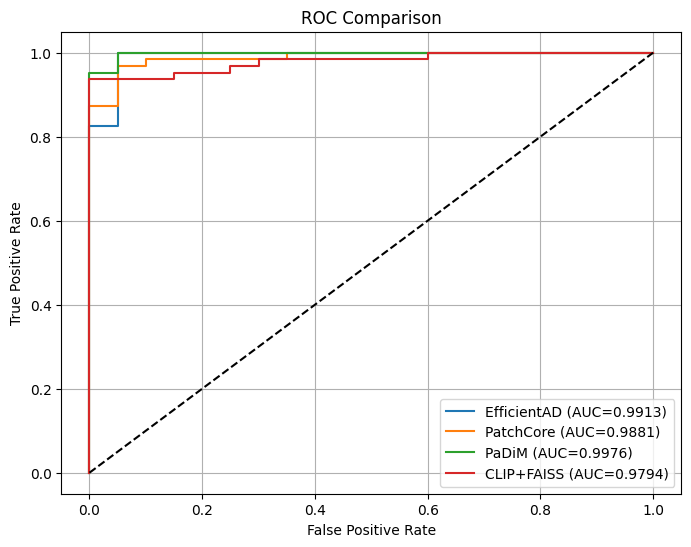

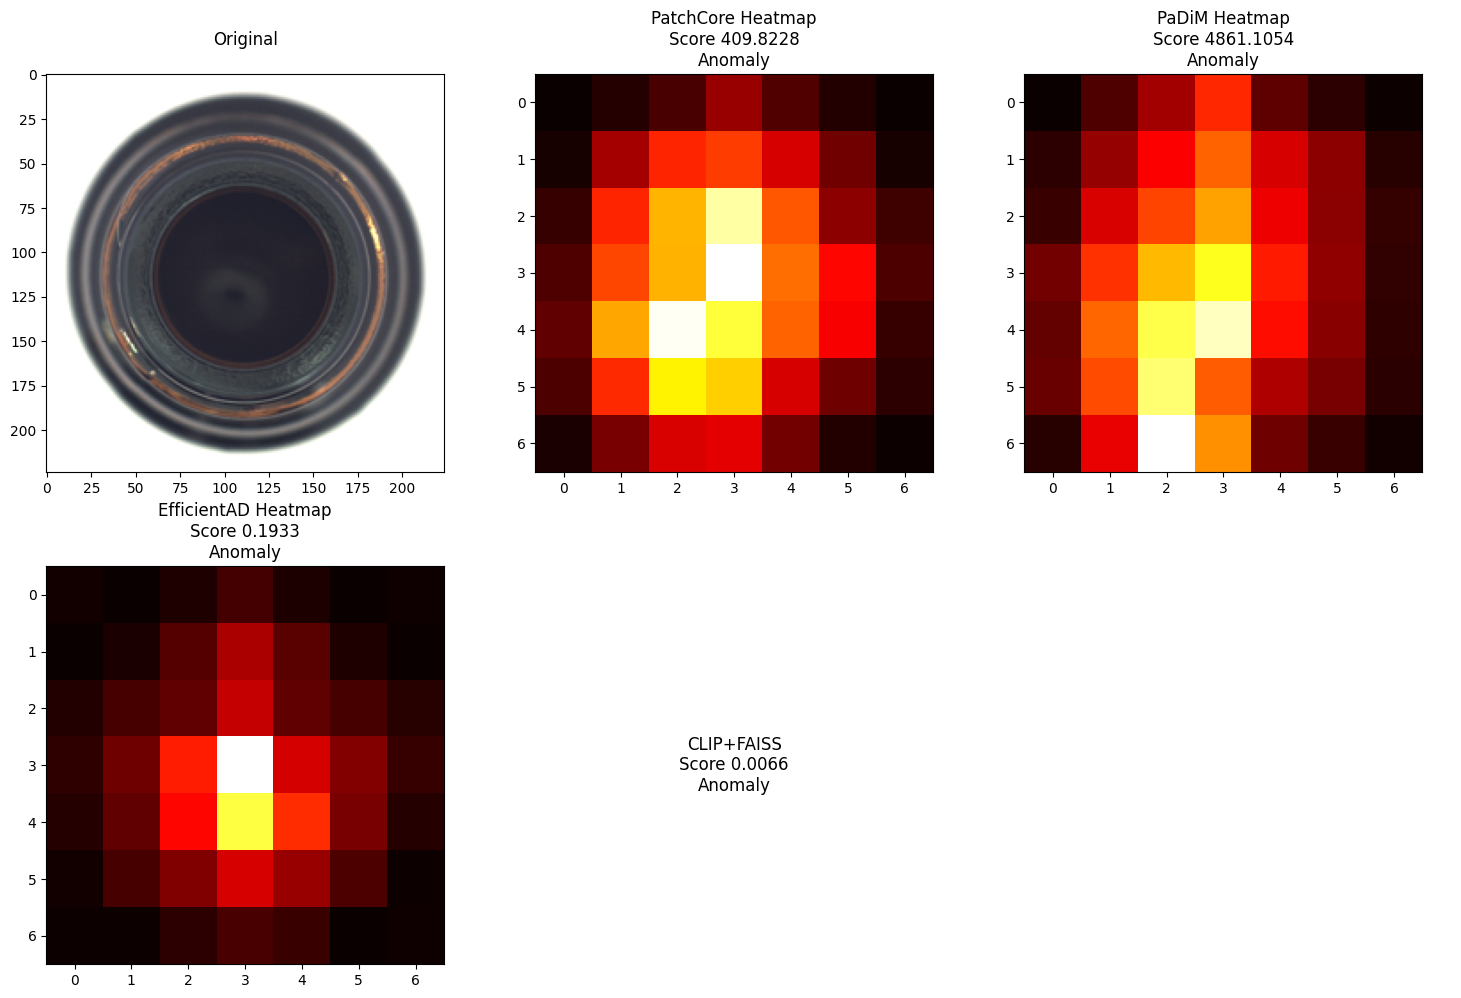

In [11]:

root_dir = "/kaggle/input/mvtec-ad"  # Change to your path
category = "bottle"

# 2) Train and evaluate all models
models_dict = main(root_dir, category)

# 3) Inference on a new image
test_img = os.path.join(root_dir, category, "test", "broken_large", "002.png")
test_img = '/kaggle/input/mvtec-ad/bottle/test/good/006.png'
unified_infer(models_dict, test_img)

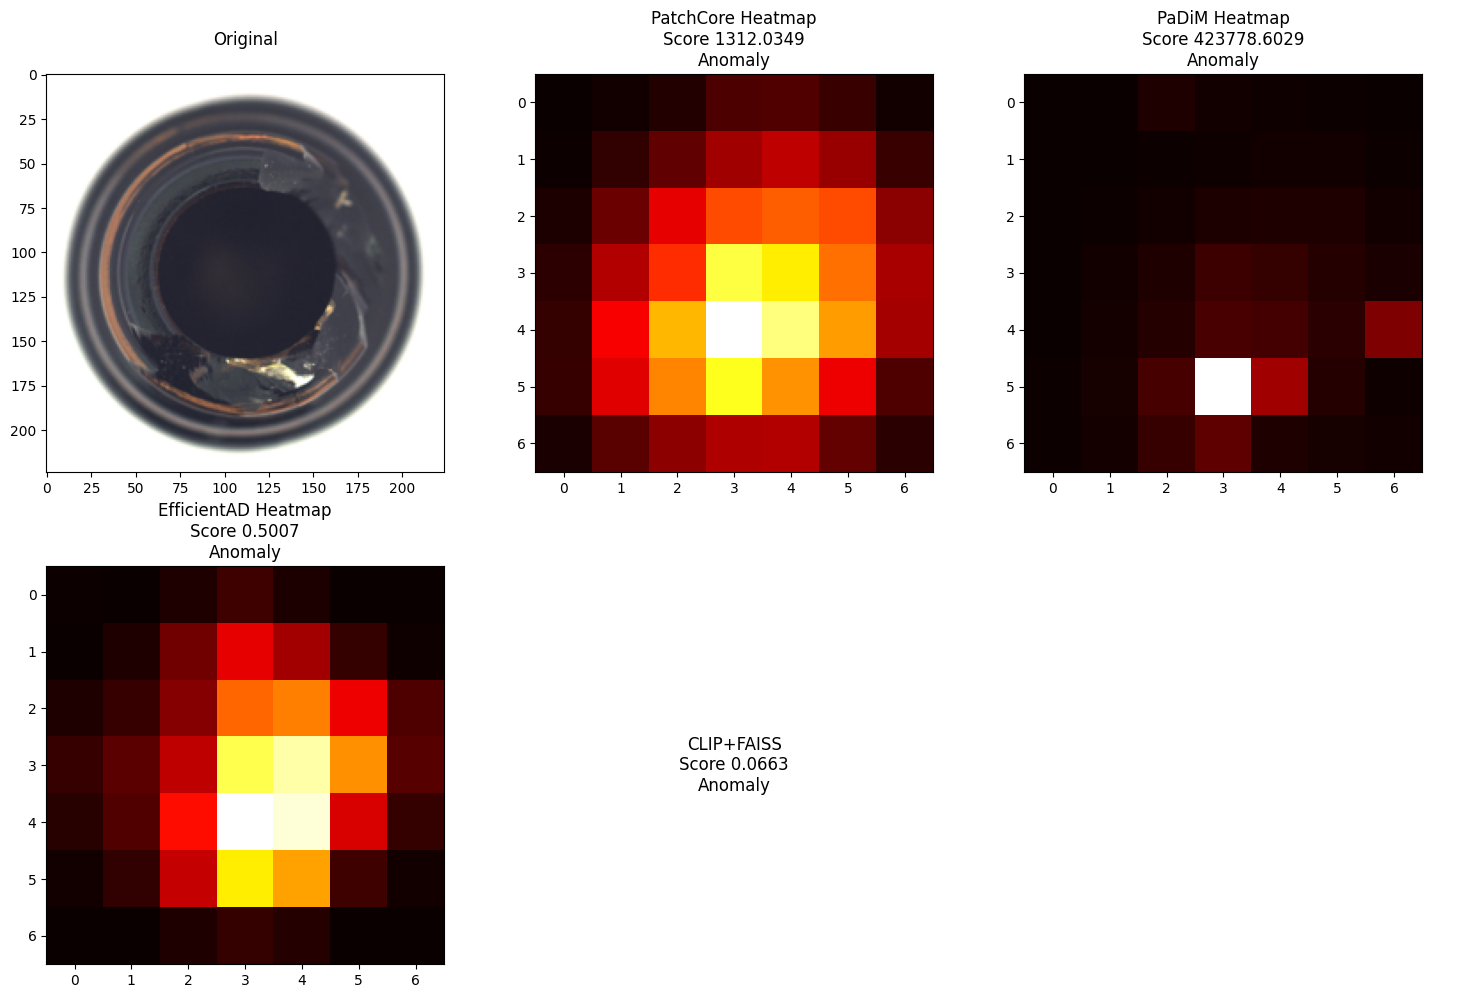

In [14]:
# 3) Inference on a new image
# test_img = os.path.join(root_dir, category, "test", "broken_large", "002.png")
test_img = '/kaggle/input/mvtec-ad/bottle/test/broken_large/016.png'
unified_infer(models_dict, test_img)